In [52]:
import re
import time
import os
import cv2
import numpy as np
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from tensorflow.keras.preprocessing.image import img_to_array,load_img

# optional
# from google.colab.patches import cv2_imshow
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline


# Enable GPU dynamic memory allocation (do not use this for colab)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


- Loading the model

In [2]:
# /content/drive/MyDrive/ANPR/training/my-models/my_ssd_resnet50_v1_fpn_640x6400
PATH_TO_SAVED_MODEL = "exported-models/my_ssd_resnet50_v1_fpn_640x6400/saved_model"
# exported-models\my_ssd_resnet50_v1_fpn_640x6400\
PATH_TO_LABELS = "annotations/label_map.pbtxt"

print('Loading Model...')
start_time = time.time()
loaded_model = tf.saved_model.load(PATH_TO_SAVED_MODEL)

# Loading the pbtxt
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

print('Done! Took {} seconds'.format(time.time() - start_time))

Loading Model...
Done! Took 38.92940425872803 seconds


- Checking the signature of the models i.e output shapes, datatypes and inputs

In [5]:
print(loaded_model.signatures['serving_default'].inputs[0])
print(loaded_model.signatures['serving_default'].output_dtypes)
print(loaded_model.signatures['serving_default'].output_shapes)
# Here the input is expected in uint8 dtype, but our is in float32. So we need to convert that below.

Tensor("input_tensor:0", shape=(1, None, None, 3), dtype=uint8)
{'detection_anchor_indices': tf.float32, 'detection_boxes': tf.float32, 'detection_classes': tf.float32, 'detection_multiclass_scores': tf.float32, 'detection_scores': tf.float32, 'num_detections': tf.float32, 'raw_detection_boxes': tf.float32, 'raw_detection_scores': tf.float32}
{'detection_anchor_indices': TensorShape([1, 100]), 'detection_boxes': TensorShape([1, 100, 4]), 'detection_classes': TensorShape([1, 100]), 'detection_multiclass_scores': TensorShape([1, 100, 2]), 'detection_scores': TensorShape([1, 100]), 'num_detections': TensorShape([1]), 'raw_detection_boxes': TensorShape([1, 51150, 4]), 'raw_detection_scores': TensorShape([1, 51150, 2])}


- ### Making group predicition

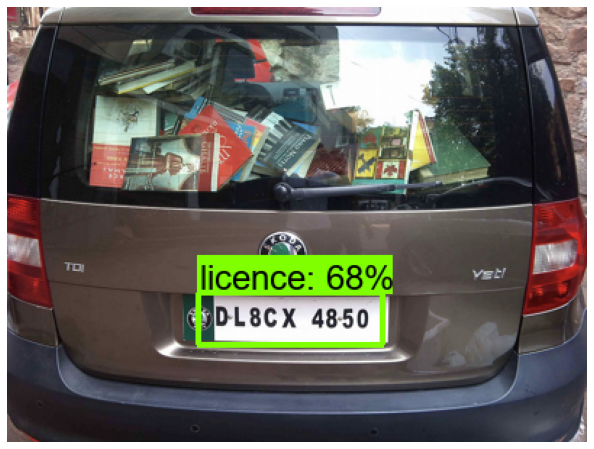

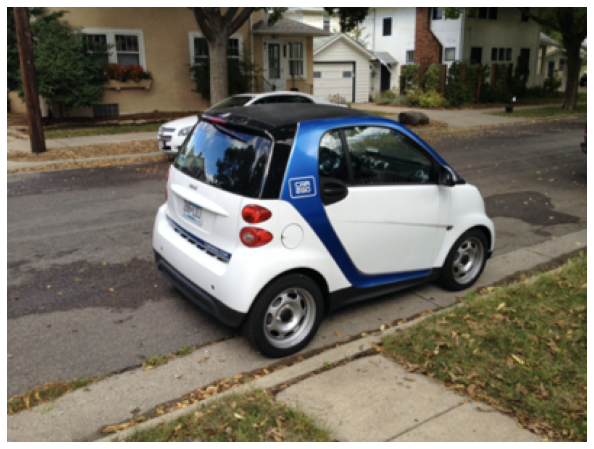

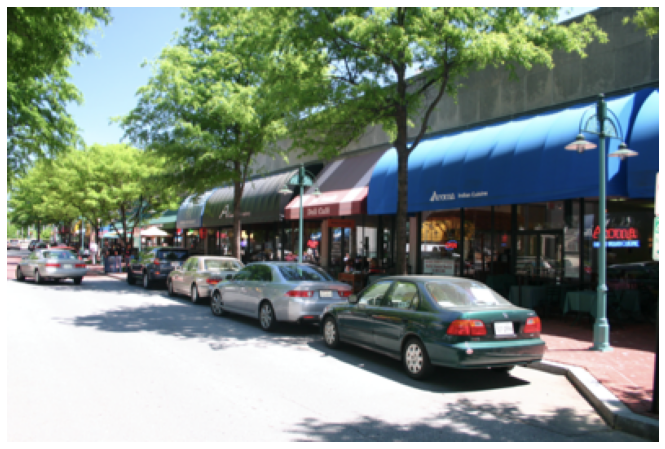

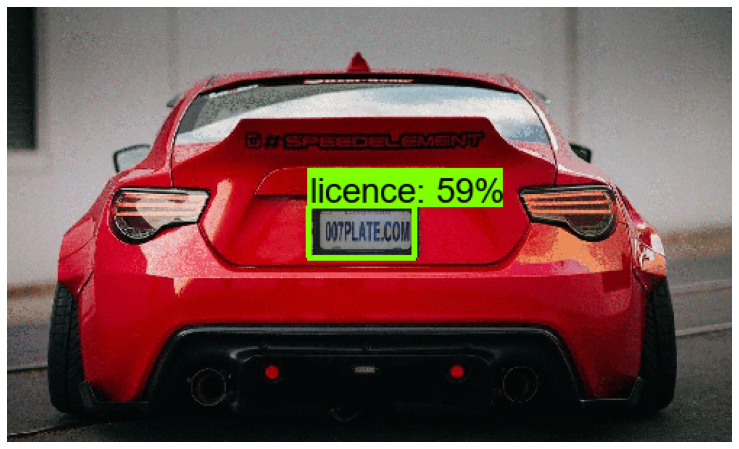

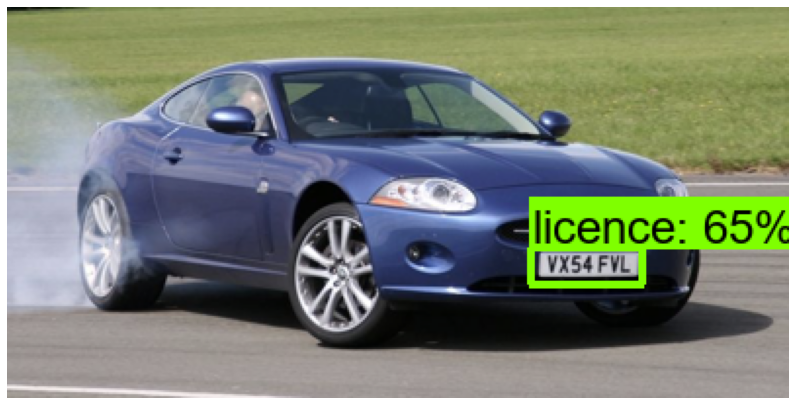

In [8]:
for path in os.listdir('images/ocr-samples')[:5]:
    test_image_o = cv2.imread('images/ocr-samples/'+path)
    test_image_rgb = cv2.cvtColor(test_image_o, cv2.COLOR_BGR2RGB)
    test_image_array_ex = np.expand_dims(test_image_rgb, axis=0)
    # Image to Tensor
    test_image_tensor = tf.convert_to_tensor(test_image_array_ex)
    test_image_tensor = tf.cast(test_image_tensor, tf.uint8) #changinig the dtype according to serving_default.

    # Predictions
    prediction = loaded_model(test_image_tensor)

    num_bboxes = int(prediction.pop('num_detections'))
    prediction = {key: value[0, :num_bboxes].numpy()
                   for key, value in prediction.items()}
    prediction['num_detections'] = num_bboxes
    prediction['detection_classes'] = prediction['detection_classes'].astype(np.int64)

    # Drwaing Bbox and OCR
    output_image = test_image_o.copy()
    threshold = 0.55
    valid_predictions = sum(prediction['detection_scores']>=threshold)
    for i in range(valid_predictions):
        ymin, xmin, ymax, xmax = prediction['detection_boxes'][i]
        im_height, im_width = test_image_o.shape[:2]
        (x1, x2, y1, y2) = (int(xmin * im_width), int(xmax * im_width),int(ymin * im_height), int(ymax * im_height))
        score = prediction['detection_scores'][i]
        cv2.rectangle(output_image, (x1,y1), (x2,y2),(0, 255, 0), 2)
        crop_img = test_image_o[y1:y2, x1:x2]
        text = str(pytesseract.image_to_string(crop_img,config='--psm 10'))
        text = re.sub(r"^[A-Za-z0-9 ]*$",'',text).strip()
        tag = text+ ' -> '+ str(round(score*100,1))
        cv2.putText(output_image,text,(x1-10,y1-10),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
        cv2.putText(output_image,str(round(score*100,1)),(x1+10,y2+10),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)

    fig = plt.figure(figsize=(12,6))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.show()

- Single prediction

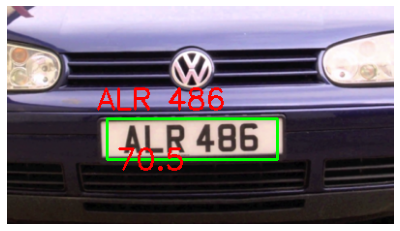

In [99]:
def single_pred(path):
    # Image to array
    test_image_o = cv2.imread(path)
    test_image_rgb = cv2.cvtColor(test_image_o, cv2.COLOR_BGR2RGB)
    test_image_array_ex = np.expand_dims(test_image_rgb, axis=0)

    # Image to Tensor
    test_image_tensor = tf.convert_to_tensor(test_image_array_ex)
    test_image_tensor = tf.cast(test_image_tensor, tf.uint8) #changinig the dtype according to serving_default.

    # Predictions
    prediction = loaded_model(test_image_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.

    num_bboxes = int(prediction.pop('num_detections'))
    prediction = {key: value[0, :num_bboxes].numpy()
                   for key, value in prediction.items()}
    prediction['num_detections'] = num_bboxes

    # detection_classes should be ints.
    prediction['detection_classes'] = prediction['detection_classes'].astype(np.int64)

    # Drwaing Bbox and OCR
    output_image = test_image_o.copy()
    threshold = 0.4
    valid_predictions = sum(prediction['detection_scores']>=threshold)
    for i in range(valid_predictions):
        ymin, xmin, ymax, xmax = prediction['detection_boxes'][i]
        score = prediction['detection_scores'][i]
        im_height, im_width = test_image_o.shape[:2]
        (x1, x2, y1, y2) = (int(xmin * im_width), int(xmax * im_width),int(ymin * im_height), int(ymax * im_height))
        cv2.rectangle(output_image, (x1,y1), (x2,y2),(0, 255, 0), 2)
        crop_img = test_image_o[y1:y2, x1:x2]
        # To grayscale
        # crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
        # Binarization
        # crop_img = cv2.adaptiveThreshold(crop_img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
        text = str(pytesseract.image_to_string(crop_img,config='--psm 10'))
        text = re.sub(r"^[A-Za-z0-9 ]*$",'',text).strip()
        tag = text+ ' -> '+ str(round(score*100,1))
        cv2.putText(output_image,text,(x1-10,y1-10),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
        cv2.putText(output_image,str(round(score*100,1)),(x1+10,y2+10),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)

    fig = plt.figure(figsize=(8,4))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.show()
    # Image.fromarray(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB), 'RGB')
    # Image.fromarray(crop_img, None)
single_pred('images/train/Cars187.png')
# single_pred('images/ocr-samples/car105.jpg')

- ### Video prediction

In [25]:
def show_inference(model,frame):
    test_image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # OpenCV reads images in BGR format. So for us to work we need RGB format.
    test_image_array_ex = np.expand_dims(test_image_rgb, axis=0)

    test_image_tensor = tf.convert_to_tensor(test_image_array_ex)
    test_image_tensor = tf.cast(test_image_tensor, tf.uint8) #changinig the dtype according to serving_default.

    # Predictions
    prediction = loaded_model(test_image_tensor)

    num_bboxes = int(prediction.pop('num_detections'))
    prediction = {key: value[0, :num_bboxes].numpy() for key, value in prediction.items()}
    prediction['num_detections'] = num_bboxes

    # detection_classes should be ints.
    prediction['detection_classes'] = prediction['detection_classes'].astype(np.int64)

    image_with_detections = test_image_rgb.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_with_detections,
          prediction['detection_boxes'],
          prediction['detection_classes'],
          prediction['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=5,
          min_score_thresh=0.2,
          agnostic_mode=False)

    return image_with_detections


In [28]:
# cap = cv2.VideoCapture(0)
# if not cap.isOpened():
#     print("Cannot open camera")
#     exit()

cap = cv2.VideoCapture('images/test-videos/vid3.mp4')


# Define the codec and create VideoWriter object
# saving the video
# fourcc = cv.VideoWriter_fourcc(*'XVID')
# out = cv.VideoWriter('output.avi', fourcc, 20.0, (640,  480))

while True:
    cv2.namedWindow('image',cv2.WINDOW_NORMAL)
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Our operations on the frame come here
    inference = show_inference(loaded_model,frame)
    inference = cv2.cvtColor(inference, cv2.COLOR_RGB2BGR) # Again converting our RGB to CV2 required BGR
    # saving the video stream
    # out.write(frame)

    # Display the resulting frame
    cv2.imshow('image', inference)
    cv2.resizeWindow('image', 800,550)
    if cv2.waitKey(1) == ord('q'):
        break

# When everything done, release the capture
cap.release()
# out.release() #saving the video stream
cv2.destroyAllWindows()

In [ ]:
# def _imports_graph_def():
#     tf.compat.v1.import_graph_def(graph_def, name="")
# def wrap_frozen_graph(graph_def, inputs, outputs, print_graph=False):
#     wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
#     import_graph = wrapped_import.graph

#     # print("-" * 50)
#     # print("Frozen model layers: ")
#     layers = [op.name for op in import_graph.get_operations()]
#     # if print_graph == True:
#         # for layer in layers:
#             # print(layer)
#     # print("-" * 50)

#     return wrapped_import.prune(
#         tf.nest.map_structure(import_graph.as_graph_element, inputs),
#         tf.nest.map_structure(import_graph.as_graph_element, outputs))

# with tf.io.gfile.GFile("exported-models/ineuron/frozen_inference_graph.pb", "rb") as f:
#     graph_def = tf.compat.v1.GraphDef()
#     loaded = graph_def.ParseFromString(f.read())

#     # Wrap frozen graph to ConcreteFunctions
#     frozen_func = wrap_frozen_graph(graph_def=graph_def,
#                                     inputs=["x:0"],
#                                     outputs=["Identity:0"],
#                                     print_graph=True)